# Finetuning Notebook for NeuroBench

### Imports

In [1]:
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler
import os
import pickle
from tqdm import tqdm
import lightning as L
import torch.nn as nn
from torch.utils.data import random_split
from lightning.pytorch.callbacks import ModelCheckpoint
import sys
import random
from collections import Counter
from collections import defaultdict

sys.path.append("/home/maxihuber/eeg-foundation/")
L.seed_everything(42)

[rank: 0] Seed set to 42


42

### Shorten Jsons for Debugging

In [ ]:
def shorten_json(data_index_path, store_path, num_samples):
    with open(data_index_path, 'r') as f:
        index_dict = json.load(f)
    short_index_dict = {}
    task_name = list(index_dict.keys())[0]
    short_index_dict[task_name] = [sample for sample in index_dict[task_name][:num_samples]]
    short_index_dict["task_type"] = index_dict["task_type"]
    with open(store_path, 'w') as file:
        json.dump(short_index_dict, file)
        print(f"Stored to {store_path}")

shorten_json("/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_train.json",
             "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_train_small.json",
             50)

shorten_json("/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_val.json",
             "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_val_small.json",
             10)

shorten_json("/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_test.json",
             "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_test_small.json",
             20)

### Adjust pathnames from kard -> maxihuber

In [ ]:
def adjust_json_paths(data_index_path, store_path):
    with open(data_index_path, 'r') as f:
        index_dict = json.load(f)
    
    index_dict_new = {}
    task_name = list(index_dict.keys())[0]
    index_dict_new[task_name] = []  # Initialize the list for the task
    
    for sample in index_dict[task_name]:
        new_input = []
        for file_path in sample["input"]:
            # Remove the /itet-stor/kard path prefix and replace with /itet-stor/maxihuber
            modified_path = file_path.replace("/itet-stor/kard", "/itet-stor/maxihuber")
            new_input.append(modified_path)
        sample["input"] = new_input
        index_dict_new[task_name].append(sample)
    
    index_dict_new["task_type"] = index_dict["task_type"]
    
    with open(store_path, 'w') as file:
        json.dump(index_dict_new, file)
        print(f"Stored to {store_path}")

adjust_json_paths("/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_train.json",
                  "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_train.json")

adjust_json_paths("/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_val.json",
                  "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_val.json")

adjust_json_paths("/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_test.json",
                  "/itet-stor/maxihuber/deepeye_storage/index_files/EEGEyeNet_Direction_test.json")

### Load Train/Val/Test Information

In [2]:
with open('/home/maxihuber/eeg-foundation/src/data/components/channels_to_id.json', 'r') as f:
    pkl_channels = set(json.load(f).keys())
    cli_channels = set(['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 
                     'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 
                     'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 
                     'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 
                     'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 
                     'FT7', 'FT8', 'Fp1', 'Fp2', 'Fz', 'Mastoids', 
                     'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 
                     'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP7', 'TP8', 
                     'Veog', 'X', 'Y', 'Z'])
task_channels = pkl_channels | cli_channels

cli_class = {
    "class_name": "Clinical",
    "time_col": "Time in Seconds",
    "prefix_filepath": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_prepared/",
    "load_mode": 0,
}

age = {
    "task_name": "Age",
    "task_type": "Regression",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_tasks/age.json",
    "out_dim": 1,
}

depression = {
    "task_name": "Depression",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_tasks/cli_depression.json",
    "out_dim": 2,
}

parkinsons = {
    "task_name": "Parkinsons",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_tasks/cli_parkinsons.json",
    "out_dim": 2,
}

schizophrenia = {
    "task_name": "Schizophrenia",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_tasks/cli_schizophrenia.json",
    "out_dim": 2,
}

sex = {
    "task_name": "Sex",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_clinical_tasks/sex.json",
    "out_dim": 2,
}


########################################################################################################################

mi_class = {
    "class_name": "Motor Imagery",
    "time_col": "time in seconds",
    "prefix_filepath": "/itet-stor/maxihuber/deepeye_storage/foundation_prepared/",
    "load_mode": 0,
}

eye_open_closed = {
    "task_name": "EyeOpenClosed",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/eye_open_closed.json",
    "out_dim": 2,
    "outputs": set(['eye open', 'eye closed']),
}

eye_vh = {
    "task_name": "EyeVH",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/eye_vh.json",
    "out_dim": 2,
    "outputs": set(['vertical', 'horizontal']),
}

flexion_extension_imaginary = {
    "task_name": "FlexionExtensionImaginary",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/flexion_extension_imaginary.json",
    "out_dim": 2,
    "outputs": set(['hand movement imagined elbow flexion', 'hand movement imagined elbow extension']),
}

flexion_extension_real = {
    "task_name": "FlexionExtensionReal",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/flexion_extension_real.json",
    "out_dim": 2,
    "outputs": set(['hand movement elbow extension', 'hand movement elbow flexion']),
}

grasp_real = {
    "task_name": "GraspReal",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/grasp_real.json",
    "out_dim": 2,
    "outputs": set(['movement palmar grasp', 'movement lateral grasp']),
}

lr_imaginary = {
    "task_name": "LRImaginary",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/lr_imaginary.json",
    "out_dim": 2,
    "outputs": set(['left hand imagined movement', 'right hand imagined movement']),
}

lr_real = {
    "task_name": "LRReal",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/lr_real.json",
    "out_dim": 2,
    "outputs": set(['right hand movement', 'left hand movement']),
}

mi_task_body_parts = {
    "task_name": "BodyParts",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/mi_task_body_parts.json",
    "out_dim": 4,
    "outputs": set(['rest', 'right hand movement', 'foot movement', 'left hand movement']),
}

pronation_supination_real = {
    "task_name": "PronationSupinationReal",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/pronation_supination_real.json",
    "out_dim": 2,
    "outputs": set(['movement supination', 'movement pronation']),
}

pronation_supination_imaginary = {
    "task_name": "PronationSupinationImaginary",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/mi/pronation_supination_imaginary.json",
    "out_dim": 2,
    "outputs": set(['imagined supination', 'imagined pronation']),
}

########################################################################################################################

erp_class = {
    "class_name": "Error-Related Potential",
    "time_col": "time in seconds",
    "prefix_filepath": "/itet-stor/maxihuber/deepeye_storage/foundation_prepared/",
    "load_mode": 0
}

erp = {
    "task_name": "ERP",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/erp/erp_all.json",
    "out_dim": 5,
    "outputs": set(['Participant is in resting state', 'with event-related potential', 
                    'Participant is in interval between two flashes', 'without event-related potential', 
                    'Participant keeps closing eyes']),
}

errp = {
    "task_name": "ERRP",
    "task_type": "Classification",
    "json_path": "/itet-stor/maxihuber/deepeye_storage/foundation_tasks/erp/errp_all.json",
    "out_dim": 7,
    "outputs": set(['Target is located in the right', 'without error-related potential', 
                    'The cursor moves to the left', 'The feedback consisted in the selected item is presented on the screen',
                    'The cursor moves to the right', 'with error-related potential', 'Target is located in the left']),
}

########################################################################################################################

eye_class = {
    "class_name": "EyeNet",
    "time_col": "time",
    "prefix_filepath": "/itet-stor/maxihuber/deepeye_storage/foundation_prepared/",
    "load_mode": 1
}

eye_dir_amp = {
    "task_name": "EyeNetDirectionAmp",
    "task_type": "Regression",
    "json_path": ['/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Amp_train.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Amp_val.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Amp_test.json'],
    "out_dim": 1,
}

eye_dir_ang = {
    "task_name": "EyeNetDirectionAng",
    "task_type": "Regression",
    "json_path": ['/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Ang_train.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Ang_val.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Direction_Ang_test.json'],
    "out_dim": 1,
}

eye_lr = {
    "task_name": "EyeNetLR",
    "task_type": "Classification",
    "json_path": ['/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_LR_train.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_LR_val.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_LR_test.json'],
    "out_dim": 2,
}

eye_position = {
    "task_name": "EyeNetPosition",
    "task_type": "Regression",
    "json_path": ['/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Position_train.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Position_val.json',
                 '/itet-stor/maxihuber/deepeye_storage/eegeyenet_tasks/EEGEyeNet_Position_test.json'],
    "out_dim": 2,
}

### Load data into memory

In [ ]:
used_class = cli_class
class_name = used_class["class_name"]
time_col = used_class["time_col"]
prefix_filepath = used_class["prefix_filepath"]
load_mode = used_class["load_mode"]

used_task = depression
task_name = used_task["task_name"]
task_type = used_task["task_type"]
json_path = used_task["json_path"]
out_dim = used_task["out_dim"]

balance_datasets = True

def load_index0(data_index_path):
    with open(data_index_path, 'r') as f:
        train_test_dict = json.load(f)
    train_samples = train_test_dict['train']
    test_samples = train_test_dict['test']
    return train_samples, test_samples

def load_index1(data_index_paths):
    all_samples = []
    for data_index_path in data_index_paths:
        with open(data_index_path, 'r') as f:
            subset_dict = json.load(f)
        all_samples.append(list(subset_dict.values())[0])
    return all_samples[0], all_samples[1], all_samples[2]

dataset_dict = {
    "ERP_ERP_ANA": 0, "RS_RS_ALPHA": 1, "ERP_ERP_BISC": 2, "ERP_ERP_BBI": 3, 
    "ERP_ERP_BICF": 4, "ERP_ERP_BICD": 5, "RS_RS_SPIS": 6, "MI_MI_HGD": 7, 
    "MI_MI_SCP": 8, "ErrP_ErrP_MERP": 9, "MI_MI_ULM": 10, "MI_MI_VEP": 11, 
    "MI_MI_LR": 12, "MI_BBCI_IV_Graz_b": 13, "MI_MI_EB": 14, "MI_BBCI_IV_Graz_a": 15, 
    "MI_MI_GVH_V": 16, "MI_MI_GAL": 17, "MI_MI_Two": 18, "MI_MI_GVH_H": 19, 
    "MI_MI_II": 20, "ErrP_ErrP_BCI": 21, "MI_MI_GVH_G": 22, "MI_MI_Limb": 23, 
    "MI_MI_SCI": 24, "MI_BBCI_IV_Berlin": 25, "MI_eegmmidb": 26, "ERP_ERP_FHD": 27, 
    "RS_RS_EID": 28
}

def extract_dataset_name(file_path, dataset_dict):
    for name in dataset_dict.keys():
        if name in file_path:
            return name
    return "Unknown"


def load_file_data(data_index, task_channels):
    num_samples = 0
    data = {}
    outputs = {}
    srs = {}
    durs = {}
    channels = {}
    datasets = {}
    failed_samples = []

    for sample in tqdm(data_index, desc="Loading data", position=0, leave=True):
        try:
            # Load and concatenate dataframe
            input_files = sample["input"]
            df = pd.DataFrame()
            for file in input_files:
                if load_mode != 1:
                    file = prefix_filepath + file
                else:
                    file = file.replace("/itet-stor/kard", "/itet-stor/maxihuber")
                with open(file, 'rb') as f:
                    df_new = pd.read_pickle(f)
                    df = pd.concat([df, df_new], axis=0)
                dataset_name = extract_dataset_name(file, dataset_dict)
                datasets[num_samples] = dataset_name

            start = int(sample["start"])
            length = int(sample["length"]) if "length" in sample else int(sample["end"])
            if load_mode != 1:
                df = df.iloc[start:length, :]
            else:
                df = df.loc[start:start+length, :]
            
            # Add metadata
            if len(df) <= 1:
                continue
            sr = int(1 / float(float(df[time_col].iloc[1]) - float(df[time_col].iloc[0])))
            if load_mode != 1:
                outputs[num_samples] = sample["output"] if "output" in sample else sample["label"]
            else:
                if task_name == "EyeNetPosition":
                    outputs[num_samples] = list(sample["output"].values())
                else:
                    outputs[num_samples] = list(sample["output"].values())[0]
            srs[num_samples] = sr
            durs[num_samples] = len(df) / sr
            channels[num_samples] = list(set(df.columns) & task_channels)
            df = df[channels[num_samples]].astype(float)
            signals = torch.tensor(df.to_numpy(), dtype=torch.float32).T
            data[num_samples] = signals
            num_samples += 1
        
        except Exception as e:
            print(f"Failed to process sample: {sample}. Error: {e}")
            failed_samples.append(sample)
    
    return data, outputs, srs, durs, channels, datasets

def balance_dataset(data, outputs, sr, dur, channels, datasets):
    # Step 1: Count samples per class
    class_counts = Counter(outputs.values())
    print("Before balancing:", class_counts)
    
    # Step 2: Determine the desired number of samples per class
    nr_samples = int(min(class_counts.values()))
    
    # Step 3: Randomly select samples for each class
    balanced_indices = []
    for cls in class_counts:
        cls_indices = [i for i, label in enumerate(outputs.values()) if label == cls]
        selected_indices = random.sample(cls_indices, nr_samples)
        balanced_indices.extend(selected_indices)
    tmp = """
    balanced_indices = []
    for cls in class_counts:
        cls_indices = [i for i, label in enumerate(outputs.values()) if label == cls]
        if len(cls_indices) < nr_samples:
            selected_indices = cls_indices
        else:
            selected_indices = sorted(random.sample(cls_indices, nr_samples))
        balanced_indices.extend(selected_indices)
    """
    tmp = """
    balanced_indices = []
    for cls in class_counts:
        cls_indices = [i for i, label in enumerate(datasets.values()) if label == cls]
        if len(cls_indices) < nr_samples:
            # Duplicate indices to reach the desired number of samples
            repeats = (nr_samples // len(cls_indices)) + 1
            selected_indices = (cls_indices * repeats)[:nr_samples]
        else:
            # Randomly sample without replacement
            selected_indices = sorted(random.sample(cls_indices, min(nr_samples, len(cls_indices))))
        balanced_indices.extend(selected_indices)
    """

    balanced_data = {i: data[idx] for i, idx in enumerate(balanced_indices)}
    balanced_outputs = {i: outputs[idx] for i, idx in enumerate(balanced_indices)}
    balanced_sr = {i: sr[idx] for i, idx in enumerate(balanced_indices)}
    balanced_dur = {i: dur[idx] for i, idx in enumerate(balanced_indices)}
    balanced_channels = {i: channels[idx] for i, idx in enumerate(balanced_indices)}
    balanced_datasets = {i: datasets[idx] for i, idx in enumerate(balanced_indices)}

    class_counts2 = Counter(balanced_outputs.values())
    print("After balancing:", class_counts2)
    
    return balanced_data, balanced_outputs, balanced_sr, balanced_dur, balanced_channels, balanced_datasets


if load_mode == 0:
    train_index, test_index = load_index0(json_path)
elif load_mode == 1:
    train_index, val_index, test_index = load_index1(json_path)
else:
    pass

print(f"Full train size: {len(train_index)}")
print(f"Full test size: {len(test_index)}")

if load_mode == 0:
    train_index = train_index
    test_index = test_index
elif load_mode == 1:
    train_index = train_index
    val_index = val_index
    test_index = test_index
else:
    pass


if load_mode == 0:
    train_data, train_outputs, train_sr, train_dur, train_channels, train_datasets = load_file_data(train_index, task_channels)
    test_data, test_outputs, test_sr, test_dur, test_channels, test_datasets = load_file_data(test_index, task_channels)
    #train_data, train_outputs, train_sr, train_dur, train_channels, train_datasets = balance_dataset(train_data, 
    #                                                                                                 train_outputs,
    #                                                                                                 train_sr,
    #                                                                                                 train_dur,
    #                                                                                                 train_channels,
    #                                                                                                 train_datasets)
elif load_mode == 1:
    train_data, train_outputs, train_sr, train_dur, train_channels, train_datasets = load_file_data(train_index, task_channels)
    val_data, val_outputs, val_sr, val_dur, val_channels, val_datasets = load_file_data(val_index, task_channels)
    test_data, test_outputs, test_sr, test_dur, test_channels, test_datasets = load_file_data(test_index, task_channels)
else:
    pass
    

# Label Encoder & Class Weights
from sklearn.preprocessing import LabelEncoder

if isinstance(list(train_outputs.values())[0], str):
    all_outputs = list(set(list(train_outputs.values()) + list(test_outputs.values())))
    label_encoder = LabelEncoder()
    label_encoder.fit(all_outputs)

    print(f"Train classes: {set(train_outputs.values())}")
    print(f"Test classes: {set(test_outputs.values())}")
    
    # Encode the train and test outputs
    encoded_train_outputs = {k: label_encoder.transform([v])[0] for k, v in train_outputs.items()}
    encoded_test_outputs = {k: label_encoder.transform([v])[0] for k, v in test_outputs.items()}

    # Create the output counts map
    train_output_counts = defaultdict(int)
    for output in encoded_train_outputs.values():
        train_output_counts[output] += 1
    
    test_output_counts = defaultdict(int)
    for output in encoded_test_outputs.values():
        test_output_counts[output] += 1
    
    full_output_counts = train_output_counts.copy()
    for output, count in test_output_counts.items():
        full_output_counts[output] += count
    
    print("Full Output Counts:", full_output_counts)
    
    # Calculate class weights
    total_count = sum(full_output_counts.values())
    class_weights = {output: total_count / count for output, count in full_output_counts.items()}
    
    # Convert class weights to a tensor
    weight_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float)
else:
    label_encoder = None
    weight_tensor = None

Full train size: 206
Full test size: 33


Loading data:   3%|███▌                                                                                                                       | 6/206 [12:01<6:29:12, 116.76s/it]

### Balance Dataset Classes (Subsample)

In [ ]:
import statistics

def balance_dataset(data, outputs):
    # Step 1: Count samples per class
    class_counts = Counter(datasets.values())
    print("Before balancing:", class_counts)
    
    # Step 2: Determine the desired number of samples per class
    nr_samples = int(statistics.median(class_counts.values()))
    
    # Step 3: Randomly select samples for each class
    balanced_indices = []
    for cls in class_counts:
        cls_indices = [i for i, label in enumerate(datasets.values()) if label == cls]
        if len(cls_indices) < nr_samples:
            # Duplicate indices to reach the desired number of samples
            repeats = (nr_samples // len(cls_indices)) + 1
            selected_indices = (cls_indices * repeats)[:nr_samples]
        else:
            # Randomly sample without replacement
            selected_indices = sorted(random.sample(cls_indices, nr_samples))
        balanced_indices.extend(selected_indices)

    balanced_data = {i: data[i] for i in balanced_indices}
    balanced_outputs = {i: outputs[idx] for i, idx in enumerate(balanced_indices)}

    class_counts2 = Counter(balanced_outputs.values())
    print("After balancing:", class_counts2)
    
    return balanced_data, balanced_outputs


train_data1, train_outputs1 = balance_dataset(train_data, train_outputs)
len(train_data1)

## EEG-Transformer

In [221]:
ckpt_path = '/itet-stor/maxihuber/net_scratch/checkpoints/980473/epoch=7-step=239317-val_loss=130.45-lr.ckpt'
ckpt_path = '/itet-stor/maxihuber/net_scratch/checkpoints/977598/epoch=0-step=32807-val_loss=133.55.ckpt'

### Plotting

{'label_LR': 'Left'}
{'label_LR': 'Right'}


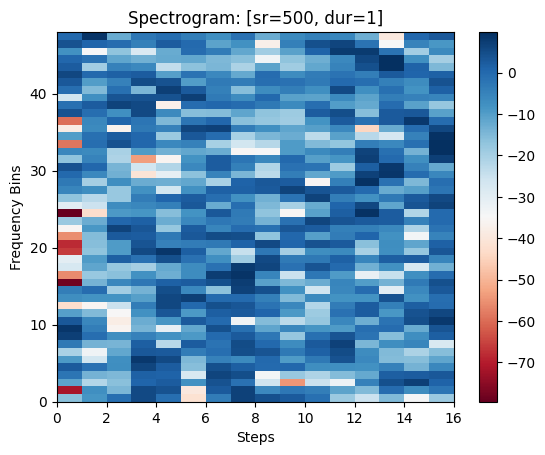

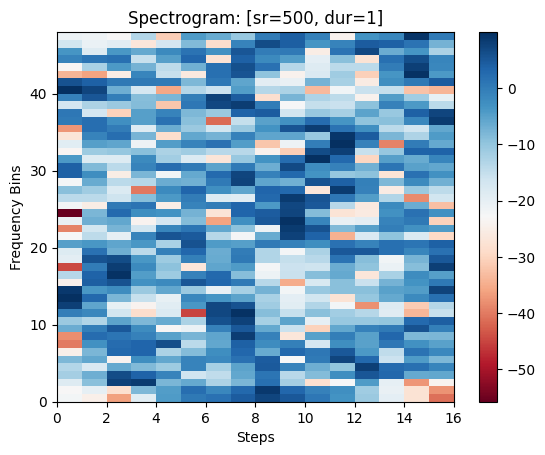

In [26]:
import matplotlib.pyplot as plt

left_paths = ["/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000004-fixation.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000005-saccade.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000006-fixation.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000007-saccade.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000008-fixation.pickle"]
right_paths = ["/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000014-fixation.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000015-saccade.pickle", "/itet-stor/kard/deepeye_storage/eegeyenet_prepared/antisaccade_task_data-synchronised_min-AA0-gip_AA0_AS_EEG-segment-000000016-fixation.pickle"]

def get_df(sample):
    input_files = sample["input"]
    df = pd.DataFrame()
    for file in input_files:
        if load_mode != 1:
            file = prefix_filepath + file
        else:
            file = file.replace("/itet-stor/kard", "/itet-stor/maxihuber")
        with open(file, 'rb') as f:
            df_new = pd.read_pickle(f)
            df = pd.concat([df, df_new], axis=0)
    start = int(sample["start"])
    length = int(sample["length"]) if "length" in sample else int(sample["end"])
    if load_mode != 1:
        df = df.iloc[start:length, :]
    else:
        df = df.loc[start:start+length, :]
    return df

left_sample = train_index[5]
print(left_sample["output"])

right_sample = train_index[1]
print(right_sample["output"])

signal_left = torch.tensor(get_df(left_sample)['E28'].to_numpy(), dtype=torch.float32)
signal_right = torch.tensor(get_df(right_sample)['E28'].to_numpy(), dtype=torch.float32)

sr = 500
dur = 1

win_size = .25
self_win_shift_factor = .25

fft = torchaudio.transforms.Spectrogram(
    n_fft=int(sr * win_size),
    win_length=int(sr * win_size),
    hop_length=int(sr * win_size * self_win_shift_factor),
    normalized=True,
)

spg_left = fft(signal_left)
spg_left = spg_left**2
spg_left = crop_spg(spg_left, self_patch_size)
spg_left, mean, std = normalize_spg(spg_left)

spg_right = fft(signal_right)
spg_right = spg_right**2
spg_right = crop_spg(spg_right, self_patch_size)
spg_right, mean, std = normalize_spg(spg_right)

def plot_spg(spg, sr, dur):
    plt.pcolormesh(spg, shading="auto", cmap="RdBu")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Steps")
    plt.title(f"Spectrogram: [sr={sr}, dur={dur}]")
    plt.colorbar(label="")
    plt.show()

plot_spg(spg_left, sr, dur)
plot_spg(spg_right, sr, dur)

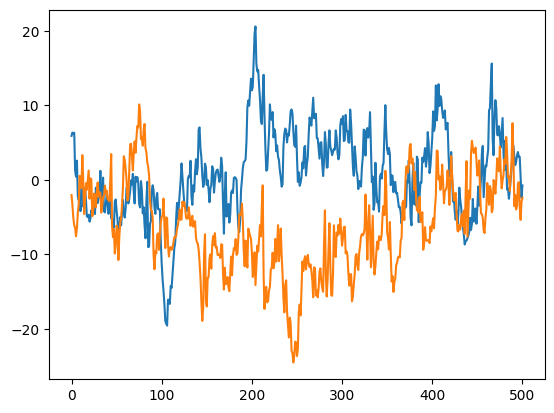

In [27]:
plt.plot(signal_left.numpy())
plt.plot(signal_right.numpy())

### Instantiate Model

In [235]:
L.seed_everything(42)
#########################################################################################################
class FinetuneDataset(Dataset):
    def __init__(self, data, outputs, srs, durs, channels, datasets, task_type, label_encoder=None):
        self.data = data
        self.outputs = outputs
        self.srs = srs
        self.durs = durs
        self.channels = channels
        self.datasets = datasets
        self.task_type = task_type
        self.label_encoder = label_encoder
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        signals = self.data[idx]
        output = self.outputs[idx]
        sr = self.srs[idx]
        dur = self.durs[idx]
        channels = self.channels[idx]
        dataset = self.datasets[idx]

        if self.task_type == "Classification" and self.label_encoder is not None:
            output = self.label_encoder.transform([output])[0]  # Encode the output label
            output_tensor = torch.tensor(output, dtype=torch.long)
        else:
            if task_name == "EyeNetPosition":
                output_tensor = torch.tensor(output, dtype=torch.float32)
            else:
                output_tensor = torch.tensor([output], dtype=torch.float32)
        
        return {
            "signals": signals,
            "output": output_tensor,
            "sr": sr,
            "dur": dur,
            "channels": channels,
            "dataset": dataset
        }

if load_mode == 0:
    full_train_dataset = FinetuneDataset(train_data, train_outputs, train_sr, train_dur, train_channels, train_datasets, task_type=task_type, label_encoder=label_encoder)
    test_dataset = FinetuneDataset(test_data, test_outputs, test_sr, test_dur, test_channels, test_datasets, task_type=task_type, label_encoder=label_encoder)
    # Define the split ratio
    train_ratio = 0.85
    val_ratio = 0.15
    # Calculate lengths for train and validation sets
    total_size = len(full_train_dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size
    # Split the dataset
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
elif load_mode == 1:
    train_dataset = FinetuneDataset(train_data, train_outputs, train_sr, train_dur, train_channels, train_datasets, task_type=task_type, label_encoder=label_encoder)
    val_dataset = FinetuneDataset(val_data, val_outputs, val_sr, val_dur, val_channels, val_datasets, task_type=task_type, label_encoder=label_encoder)
    test_dataset = FinetuneDataset(test_data, test_outputs, test_sr, test_dur, test_channels, test_datasets, task_type=task_type, label_encoder=label_encoder)
else:
    pass
    
#########################################################################################################
# DataLoaders
import torchaudio
from src.data.transforms import (
    crop_spg,
    custom_fft,
    normalize_spg,
)

self_win_shifts = [.25, .5, 1, 2, 4, 8]
self_patch_size = 16
self_win_shift_factor = .25
self_max_win_shift = self_win_shifts[-1]
self_max_y_datapoints = 4_000

def get_nr_y_patches(win_size, sr):
    return int((sr / 2 * win_size + 1) / self_patch_size)

def get_nr_x_patches(win_size, dur):
    win_shift = win_size * self_win_shift_factor
    x_datapoints_per_second = 1 / win_shift
    x_datapoints = dur * x_datapoints_per_second + 1
    return int(x_datapoints // self_patch_size)

channel_name_map_path = '/home/maxihuber/eeg-foundation/src/data/components/channels_to_id.json'
with open(channel_name_map_path, "r") as file:
    self_channel_name_map = json.load(file)

def self_get_generic_channel_name(channel_name):
    channel_name = channel_name.lower()
    # Remove "eeg " prefix if present
    if channel_name.startswith("eeg "):
        channel_name = channel_name[4:]
    # Simplify names with a dash and check if it ends with "-"
    if "-" in channel_name:
        if channel_name.endswith("-"):
            return "None"
        return channel_name.split("-")[0]
    return channel_name

def self_encode_mean(mean, win_size):
    y_datapoints = mean.shape[0]
    encoded_mean = torch.zeros(self_max_y_datapoints)
    step_size = int(self_max_win_shift // win_size)
    end_idx = step_size * y_datapoints
    indices = torch.arange(0, end_idx, step_size)
    encoded_mean[indices] = mean.squeeze_().float()
    encoded_mean.unsqueeze_(1)
    return encoded_mean

#########################################################################################################
# collate_fn
def sample_collate_fn(batch):

    signals, output, sr, dur, channels, dataset = batch[0]["signals"], batch[0]["output"], batch[0]["sr"], batch[0]["dur"], batch[0]["channels"], batch[0]["dataset"]

    if dur > 3_600:
        dur = 3_600
        signals = signals[:, :3_600*sr]
        
    # TODO: compute spectrograms for each win_size
    # gives a new dimension (S) in batch
    # need another extra transformer after the encoder
    # (B, 1, H, W) -> (S*B, 1, H, W)
    valid_win_shifts = [
        win_shift
        for win_shift in self_win_shifts
        if get_nr_y_patches(win_shift, sr) >= 1
        and get_nr_x_patches(win_shift, dur) >= 1
    ]

    # list holding assembled tensors for varying window shifts
    full_batch = {}   

    for win_size in valid_win_shifts:
        
        fft = torchaudio.transforms.Spectrogram(
            n_fft=int(sr * win_size),
            win_length=int(sr * win_size),
            hop_length=int(sr * win_size * self_win_shift_factor),
            normalized=True,
        )
    
        spg_list = []
        chn_list = []
        mean_list = []
        std_list = []
    
        for signal, channel in zip(signals, channels):
            
            # Channel information
            channel_name = self_get_generic_channel_name(channel)
            channel = self_channel_name_map[channel_name] if channel_name in self_channel_name_map else self_channel_name_map["None"]
    
            # Spectrogram Computation & Cropping
            spg = fft(signal)
            spg = spg**2
            spg = crop_spg(spg, self_patch_size)
            
            H_new, W_new = spg.shape[0], spg.shape[1]
            h_new, w_new = H_new // self_patch_size, W_new // self_patch_size
    
            # Prepare channel information (per-patch)
            channel = torch.full((h_new, w_new), channel, dtype=torch.float16)
            
            spg, mean, std = normalize_spg(spg)
            mean = self_encode_mean(mean, win_size)
            std = self_encode_mean(std, win_size)
            
            spg_list.append(spg)
            chn_list.append(channel)
            mean_list.append(mean)
            std_list.append(std)
        
        win_batch = torch.stack(spg_list)
        win_channels = torch.stack(chn_list)
        win_means = torch.stack(mean_list)
        win_stds = torch.stack(std_list)
        
        win_batch.unsqueeze_(1)
        win_channels = win_channels.flatten(1)
        win_means = win_means.transpose(1, 2)
        win_stds = win_stds.transpose(1, 2)
        
        full_batch[win_size] = {
            "batch": win_batch,
            "channels": win_channels,
            "means": win_means,
            "stds": win_stds
        }
        #print(f"[collate_fn] win_size={win_size}: {win_batch.shape}")
        
    # == Finished iterating over all possible window shifts
   
    return full_batch, output, dataset

train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=sample_collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=sample_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=sample_collate_fn)

#########################################################################################################
# Model
# == Metrics ==
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

from sklearn.metrics import balanced_accuracy_score

def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

from functools import partial

from src.models.mae_rope_encoder import EncoderViTRoPE
from src.models.components.vit_rope import (
    Flexible_RoPE_Layer_scale_init_Block,
    FlexibleRoPEAttention,
    compute_axial_cis,
    select_freqs_cis,
)
from timm.models.vision_transformer import Mlp as Mlp

from torch.nn import TransformerEncoderLayer
class SingleTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(SingleTransformerEncoderLayer, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(d_model, nhead)

    def forward(self, src):
        return self.encoder_layer(src)

from src.models.components.SimpleTransformer import SimpleTransformer

def mean_aggregation(tokens):
    return torch.mean(torch.stack(tokens), dim=0)

from sklearn.metrics import balanced_accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchmetrics

class FineTuningModel(L.LightningModule):
    def __init__(self, encoder, frozen_encoder, out_dim, task_name, task_type, learning_rate, mask_ratio):
        super(FineTuningModel, self).__init__()

        self.task_name = task_name
        self.task_type = task_type
        self.learning_rate = learning_rate
        self.mask_ratio = mask_ratio

        # Pretrained network
        self.encoder = encoder       
        if frozen_encoder:
            self.freeze_encoder()

        # Finetuning network
        self.finetune_time_transformer = Flexible_RoPE_Layer_scale_init_Block(
            dim=384,
            num_heads=6,
            mlp_ratio=4,
            qkv_bias=True,
            drop=0.0,
            attn_drop=0.0,
            drop_path=0.0,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            act_layer=nn.GELU,
            Attention_block=FlexibleRoPEAttention,
            Mlp_block=Mlp,
            init_values=1e-4,
        )
        
        # Single 1D transformer encoder layer
        #self.finetune_channel_transformer = SingleTransformerEncoderLayer(
        #    d_model=384,  # Match the dimension used in finetune_time_transformer
        #    nhead=1       # Number of heads in the multiheadattention models
        #)
        self.finetune_channel_transformer = SimpleTransformer(
            embed_size=384,
            max_len=8_500,
        )
        
        # Modular aggregation method on channel tokens
        self.win_shift_aggregation = mean_aggregation
        
        if task_type == "Regression":
            self.head = nn.Linear(encoder.encoder_embed_dim, out_dim)
            self.criterion = nn.MSELoss()
        else:
            self.head = nn.Linear(encoder.encoder_embed_dim, out_dim)
            self.criterion = nn.CrossEntropyLoss()

        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, full_x):
        
        x_embeds = {}
        H_W = {}
        
        for win_size, x_win in full_x.items():
            spgs = x_win["batch"]
            channels = x_win["channels"]
            means = x_win["means"]
            stds = x_win["stds"]
            B, C, H, W = spgs.shape
            # TODO: split into less rows if necessary because of CUDA error
            #nr_tokens = B * C * H * W
            #if nr_tokens > max_nr_tokens:
            #    pass
            x_emb, _, _, nr_meta_patches = self.encoder(
                x=spgs,
                means=means,
                stds=stds,
                channels=channels,
                win_size=win_size,
                mask_ratio=self.mask_ratio,
            )
            # TODO: 
            x_embeds[win_size] = x_emb
            H_W[win_size] = (H, W)
            #print(f"[FT.forward, after self.encoder] x_emb.shape: {x_emb.shape}")

        # Pass through time-transformer
        for win_size, x_emb in x_embeds.items():
            freqs_cis = select_freqs_cis(
                self.encoder, self.encoder.encoder_freqs_cis, H_W[win_size][0], H_W[win_size][1], win_size, x_emb.device
            )
            x_emb = self.finetune_time_transformer(x_emb, freqs_cis=freqs_cis, nr_meta_tokens=nr_meta_patches)
            #print(f"[FT.forward, after self.time_transformer] x_emb.shape: {x_emb.shape}")
            x_emb = x_emb[:, 0]
            #print(f"[FT.forward, after time-token] x_emb.shape: {x_emb.shape}")
            x_embeds[win_size] = x_emb

        # Pass through channel-transformer
        tokens = []
        for win_size, x_emb in x_embeds.items():
            x_emb = x_emb.unsqueeze(0)
            #print(f"[FT.forward, before channel-token] x_emb.shape: {x_emb.shape}")
            x_emb = self.finetune_channel_transformer(x_emb)
            x_emb = x_emb[0, 0]
            #print(f"[FT.forward, after channel-token] x_emb.shape: {x_emb.shape}")
            tokens.append(x_emb)

        #print(f"[FT.forward] len(tokens): {len(tokens)}")
        # Average over all window shifts
        smart_token = self.win_shift_aggregation(tokens)
        #print(f"[FT.forward] smart_token.shape: {smart_token.shape}")

        # Pass through head
        y_hat = self.head(smart_token)
        
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('train_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[training_step] y_hat={y_hat}, y_pred={y_pred}, y={y}, loss={loss}")
            self.train_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.train_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))
        
        return loss

    def on_train_epoch_end(self):
        self.compute_metrics(self.train_step_outputs, 'train')
        self.train_step_outputs.clear()
    
    def validation_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('val_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[validation_step] y_pred={y_pred}, y={y}, loss={loss}")
            self.validation_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.validation_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))

        return loss

    def on_validation_epoch_end(self):
        self.compute_metrics(self.validation_step_outputs, 'val')
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('test_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[test_step] y_pred={y_pred}, y={y}, loss={loss}")
            self.test_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.test_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))

        return loss

    def on_test_epoch_end(self):
        self.compute_metrics(self.test_step_outputs, 'test')
        self.test_step_outputs.clear()

    def compute_metrics(self, outputs, stage):
        y_true_all = defaultdict(list)
        y_pred_all = defaultdict(list)
        
        for y_true, y_pred, dataset in outputs:
            y_true_all[dataset].append(y_true)
            y_pred_all[dataset].append(y_pred)

        overall_y_true = []
        overall_y_pred = []

        for dataset in y_true_all.keys():
            y_true_cat = torch.stack(y_true_all[dataset])
            y_pred_cat = torch.stack(y_pred_all[dataset])

            overall_y_true.append(y_true_cat)
            overall_y_pred.append(y_pred_cat)

            if self.task_type == "Classification":
                balanced_acc = balanced_accuracy_score(y_true_cat, y_pred_cat)
                self.log(f'{stage}_balanced_accuracy_{dataset}', balanced_acc, prog_bar=True)
            elif self.task_type == "Regression":
                rmse_value = rmse(y_true_cat, y_pred_cat)
                self.log(f'{stage}_rmse_{dataset}', rmse_value, prog_bar=True)

        # Compute overall metrics
        overall_y_true = torch.cat(overall_y_true, dim=0)
        overall_y_pred = torch.cat(overall_y_pred, dim=0)

        if self.task_type == "Classification":
            balanced_acc = balanced_accuracy_score(overall_y_true, overall_y_pred)
            self.log(f'{stage}_balanced_accuracy', balanced_acc, prog_bar=True)
        elif self.task_type == "Regression":
            rmse_value = rmse(overall_y_true, overall_y_pred)
            self.log(f'{stage}_rmse', rmse_value, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.head.parameters(), lr=self.learning_rate)

    def on_train_epoch_start(self):
        if trainer.current_epoch == 1:
            self.unfreeze_encoder()
            print(f"Unfroze encoder at epoch {self.trainer.current_epoch}")
        
    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

#########################################################################################################
# Load the checkpoint
chkpt_path = ckpt_path
checkpoint = torch.load(chkpt_path, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
state_dict = {k.replace("net.encoder.", ""): v for k, v in state_dict.items() if "net.encoder." in k}

# Initialize the encoder and load the state dict
encoder = EncoderViTRoPE(channel_name_map_path)
encoder.load_state_dict(state_dict)

# Instantiate the fine-tuning model
fine_tuning_model = FineTuningModel(encoder=encoder,
                                    frozen_encoder=True,
                                    out_dim=out_dim,
                                    task_name=task_name,
                                    task_type=task_type,
                                    learning_rate=0.01,
                                    mask_ratio=0)

#########################################################################################################
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=f"/itet-stor/maxihuber/deepeye_storage/finetune_ckpts/{task_name}",
    filename="{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
)

# Train the model
trainer = L.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    num_sanity_val_steps=0,
)

print(f"Class: {class_name}")
print(f"Task: {task_name} ({task_type})")
trainer.fit(fine_tuning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

trainer.test(model=fine_tuning_model, dataloaders=test_loader)
final_checkpoint_path = f"/itet-stor/maxihuber/net_scratch/finetune_ckpts/{task_name}/final_model.ckpt"
trainer.save_checkpoint(final_checkpoint_path)

[rank: 0] Seed set to 42
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /itet-stor/maxihuber/net_scratch/conda_envs/faste ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /srv/beegfs01/projects/deepeye_storage/data/finetune_ckpts/EyeOpenClosed exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                         | Type                                 | Params | Mode 
----------------------------------------------------------------------------------------------
0 | encoder 

Class: Motor Imagery
Task: EyeOpenClosed (Classification)


Training: |                                                                                                   …

Validation: |                                                                                                 …

/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2446: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Unfroze encoder at epoch 1


/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /itet-stor/maxihuber/net_scratch/conda_envs/faste ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Test metric                ┃               DataLoader 0               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_balanced_accuracy          │            0.6944444179534912            │
│ test_balanced_accuracy_MI_BBCI_IV_Graz_a │                   1.0                    │
│ test_balanced_accuracy_MI_BBCI_IV_Graz_b │                   0.5                    │
│    test_balanced_accuracy_RS_RS_ALPHA    │            0.6666666865348816            │
│    test_balanced_accuracy_RS_RS_SPIS     │                   0.5                    │
│                test_loss                 │            1.2859755754470825            │
└──────────────────────────────────────────┴──────────────────────────────────────────┘

[{'test_loss': 1.2859755754470825,
  'test_balanced_accuracy_MI_BBCI_IV_Graz_a': 1.0,
  'test_balanced_accuracy_MI_BBCI_IV_Graz_b': 0.5,
  'test_balanced_accuracy_RS_RS_ALPHA': 0.6666666865348816,
  'test_balanced_accuracy_RS_RS_SPIS': 0.5,
  'test_balanced_accuracy': 0.6944444179534912}]

# Baseline Models

## Data Handling & Model Template

In [209]:
L.seed_everything(42)

sys.path.append('/home/maxihuber/eeg-foundation/src/models/components/Baselines')

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from torchmetrics.functional import mean_squared_error as rmse
import lightning.pytorch as L
from lightning.pytorch.callbacks import ModelCheckpoint
from collections import defaultdict


class SimpleDataset(Dataset):
    def __init__(self, data, outputs, datasets, task_type, label_encoder=None):
        self.data = data
        self.outputs = outputs
        self.datasets = datasets
        self.task_type = task_type
        self.label_encoder = label_encoder
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        signals = self.data[idx]
        output = self.outputs[idx]
        dataset = self.datasets[idx]
        
        if self.task_type == "Classification" and self.label_encoder is not None:
            output = self.label_encoder.transform([output])[0]  # Encode the output label
            output_tensor = torch.tensor(output, dtype=torch.long)
        else:
            output_tensor = torch.tensor([output], dtype=torch.float32)
        
        return {
            "signals": signals,
            "output": output_tensor,
            "dataset": dataset,
        }

durs = [df.shape[1] for idx, df in train_data.items()] + [df.shape[1] for idx, df in test_data.items()]
n_chns = [df.shape[0] for idx, df in train_data.items()] + [df.shape[0] for idx, df in test_data.items()]
dur_90 = int(np.percentile(durs, 90))
chn_90 = 128 # int(np.percentile(n_chns, 90))

def pad_tensor(tensor, target_height, target_width):
    current_height, current_width = tensor.shape

    # Pad height if necessary
    if current_height < target_height:
        padding_height = target_height - current_height
        padding = torch.zeros((padding_height, current_width), dtype=tensor.dtype)
        tensor = torch.cat((tensor, padding), dim=0)
    else:
        tensor = tensor[:target_height, :]

    # Pad width if necessary
    if current_width < target_width:
        padding_width = target_width - current_width
        padding = torch.zeros((tensor.shape[0], padding_width), dtype=tensor.dtype)
        tensor = torch.cat((tensor, padding), dim=1)
    else:
        tensor = tensor[:, :target_width]

    return tensor

train_data_pad = {k: pad_tensor(signals, chn_90, dur_90) for k, signals in train_data.items()}
test_data_pad = {k: pad_tensor(signals, chn_90, dur_90) for k, signals in test_data.items()}

full_train_dataset = SimpleDataset(train_data_pad, train_outputs, train_datasets, task_type=task_type, label_encoder=label_encoder)
test_dataset = SimpleDataset(test_data_pad, test_outputs, train_datasets, task_type=task_type, label_encoder=label_encoder)

# Define the split ratio
train_ratio, val_ratio = 0.85, 0.15

# Calculate lengths for train and validation sets
total_size = len(full_train_dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

def sample_collate_fn(batch):
    signals, output, dataset = batch[0]["signals"], batch[0]["output"], batch[0]["dataset"]
    signals = signals.unsqueeze(0)
    #print(f"[sample_collate_fn] signals.shape: {signals.shape}")
    return signals, output, dataset

# Define the baseline model class
class BaselineModel(L.LightningModule):
    def __init__(self, out_dim, task_name, task_type, learning_rate, class_weights=None):
        super(BaselineModel, self).__init__()

        self.task_name = task_name
        self.task_type = task_type
        self.learning_rate = learning_rate

        self.out_dim = out_dim
        if task_type == "Regression":
            self.criterion = nn.MSELoss()
        else:
            if class_weights is not None:
                self.criterion = nn.CrossEntropyLoss(weight=class_weights)
            else:
                self.criterion = nn.CrossEntropyLoss()

        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('train_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[training_step] y_pred={y_pred}, y={y}")
            self.train_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.train_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))
        
        return loss

    def on_train_epoch_end(self):
        self.compute_metrics(self.train_step_outputs, 'train')
        self.train_step_outputs.clear()
    
    def validation_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('val_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[validation_step] y_pred={y_pred}, y={y}")
            self.validation_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.validation_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))

        return loss

    def on_validation_epoch_end(self):
        self.compute_metrics(self.validation_step_outputs, 'val')
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, dataset = batch
        y_hat = self(x)
        loss = self.criterion(input=y_hat, target=y)
        self.log('test_loss', loss, prog_bar=True)

        if self.task_type == "Classification":
            y_pred = torch.argmax(y_hat, dim=0)
            #print(f"[test_step] y_pred={y_pred}, y={y}")
            self.test_step_outputs.append((y.cpu(), y_pred.cpu(), dataset))
        elif self.task_type == "Regression":
            self.test_step_outputs.append((y.cpu(), y_hat.cpu(), dataset))

        return loss

    def on_test_epoch_end(self):
        self.compute_metrics(self.test_step_outputs, 'test')
        self.test_step_outputs.clear()

    def compute_metrics(self, outputs, stage):
        y_true_all = defaultdict(list)
        y_pred_all = defaultdict(list)
        
        for y_true, y_pred, dataset in outputs:
            y_true_all[dataset].append(y_true)
            y_pred_all[dataset].append(y_pred)


        overall_y_true = []
        overall_y_pred = []

        for dataset in y_true_all.keys():
            y_true_cat = torch.stack(y_true_all[dataset])
            y_pred_cat = torch.stack(y_pred_all[dataset])

            overall_y_true.append(y_true_cat)
            overall_y_pred.append(y_pred_cat)

            if self.task_type == "Classification":
                balanced_acc = balanced_accuracy_score(y_true_cat, y_pred_cat)
                self.log(f'{stage}_balanced_accuracy_{dataset}', balanced_acc, prog_bar=True)
            elif self.task_type == "Regression":
                rmse_value = rmse(y_true_cat, y_pred_cat)
                self.log(f'{stage}_rmse_{dataset}', rmse_value, prog_bar=True)

        # Compute overall metrics
        overall_y_true = torch.cat(overall_y_true, dim=0)
        overall_y_pred = torch.cat(overall_y_pred, dim=0)

        if self.task_type == "Classification":
            balanced_acc = balanced_accuracy_score(overall_y_true, overall_y_pred)
            self.log(f'{stage}_balanced_accuracy', balanced_acc, prog_bar=True)
        elif self.task_type == "Regression":
            rmse_value = rmse(overall_y_true, overall_y_pred)
            self.log(f'{stage}_rmse', rmse_value, prog_bar=True)
            
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-2)

[rank: 0] Seed set to 42


# CNN ======================================================

In [210]:
L.seed_everything(42)

sys.path.append("/home/maxihuber/eeg-foundation/src/models/components/Baselines")
from src.models.components.Baselines.DL_Models.torch_models.CNN.CNN import CNN

from src.models.components.Baselines.DL_Models.torch_models.Modules import Pad_Conv, Pad_Pool
from lightning.pytorch import LightningModule
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score

class CNNBaselineModel(BaselineModel):
    def __init__(self, out_dim, task_name, task_type, learning_rate, class_weights):
        super(CNNBaselineModel, self).__init__(out_dim, task_name, task_type, learning_rate, class_weights)
        
        self.nb_features = 16  # For CNN simply the number of filters / channels
        self.nb_outlayer_channels = 1
        self.use_residual = True
        self.depth = 12
        self.kernel_size = 64
        self.nb_channels = chn_90 
        
        self.conv_blocks = nn.ModuleList([self._module(d) for d in range(self.depth)])
        if self.use_residual:
            self.shortcuts = nn.ModuleList(
                [self._shortcut(d) for d in range(int(self.depth / 3))]
            )
        self.gap_layer = nn.AvgPool1d(kernel_size=2, stride=1)
        self.gap_layer_pad = Pad_Pool(left=0, right=1, value=0)
        
        self.output_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=self.get_nb_channels_output_layer(),
                out_channels=min(self.get_nb_features_output_layer(), self.nb_outlayer_channels),
                kernel_size=1,
                stride=1,
            ),
            nn.BatchNorm1d(num_features=self.nb_outlayer_channels),
            nn.ReLU(),
            Pad_Pool(left=0, right=1, value=0),
            nn.MaxPool1d(kernel_size=2, stride=1),
        )
        self.out_linear = nn.Sequential(
            nn.Linear(dur_90, self.out_dim),
        )
    
    def _module(self, depth):
        """
        The module of CNN is made of a simple convolution with batch normalization and ReLu
        activation. Finally, MaxPooling is used. We use two custom padding modules such that
        keras-like padding='same' is achieved, i.e. tensor shape stays constant when passed through
        the module.
        """
        return nn.Sequential(
            Pad_Conv(kernel_size=self.kernel_size, value=0),
            nn.Conv1d(
                in_channels=self.nb_channels if depth == 0 else self.nb_features,
                out_channels=self.nb_features,
                kernel_size=self.kernel_size,
                bias=False,
            ),
            nn.BatchNorm1d(num_features=self.nb_features),
            nn.ReLU(),
            Pad_Pool(left=0, right=1, value=0),
            nn.MaxPool1d(kernel_size=2, stride=1),
        )

    def _shortcut(self, depth):
        """
        Implements a shortcut with a convolution and batch norm
        This is the same for all models implementing ConvNet, therefore defined here
        Padding before convolution for constant tensor shape, similar to tensorflow.keras padding=same
        """
        return nn.Sequential(
            Pad_Conv(kernel_size=self.kernel_size, value=0),
            nn.Conv1d(
                in_channels=self.nb_channels if depth == 0 else self.nb_features,
                out_channels=self.nb_features,
                kernel_size=self.kernel_size,
            ),
            nn.BatchNorm1d(num_features=self.nb_features),
        )
        
    def forward(self, x):
        """
        Implements the forward pass of the network
        Modules defined in a class implementing ConvNet are stacked and shortcut connections are
        used if specified.
        """
        #print(f"Input shape: {x.shape}")
        input_res = x  # set for the residual shortcut connection
        shortcut_cnt = 0
        for d in range(self.depth):
            x = self.conv_blocks[d](x)
            if self.use_residual and d % 3 == 2:
                res = self.shortcuts[shortcut_cnt](input_res)
                shortcut_cnt += 1
                x = torch.add(x, res)
                x = nn.functional.relu(x)
                input_res = x
        x = self.gap_layer_pad(x)
        x = self.gap_layer(x)
        output = self.output_layer(x)
        output = self.out_linear(output)
        output.squeeze_(0).squeeze_(0)
        return output

    def get_nb_features_output_layer(self):
        return self.nb_features
    
    def get_nb_channels_output_layer(self):
        return self.nb_features

[rank: 0] Seed set to 42


# EEGNet ====================================================

In [106]:
L.seed_everything(42)

from src.models.components.Baselines.DL_Models.torch_models.Modules import Pad_Conv2d

class EEG1NetBaselineModel(BaselineModel):
    def __init__(self, out_dim, task_name, task_type, learning_rate, class_weights):
        super(EEG1NetBaselineModel, self).__init__(out_dim, task_name, task_type, learning_rate, class_weights)
        
        self.nb_outlayer_channels = 1
        self.kernel_size = 32
        self.timesamples = dur_90  # Ensure this matches the number of channels in your input data
        self.channels = chn_90  # Ensure this matches the number of time samples in your input data
        self.F1 = 16
        self.D = 4
        self.F2 = 256
        self.dropout_rate = 0.5
        self.batch_size = 1

        # Block 1: 2dconv and depthwise conv
        self.padconv1 = Pad_Conv2d(kernel=(1, self.kernel_size))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=self.F1,
            kernel_size=(1, self.kernel_size),
            bias=False,
        )
        self.batchnorm1 = nn.BatchNorm2d(self.F1, False)
        self.depthwise_conv1 = nn.Conv2d(
            in_channels=self.F1,
            out_channels=self.F1 * self.D,
            groups=self.F1,
            kernel_size=(self.channels, 1),
            bias=False,
        )
        self.batchnorm1_2 = nn.BatchNorm2d(self.F1 * self.D)
        self.activation1 = nn.ELU()
        self.padpool1 = Pad_Conv2d(kernel=(1, 16))
        self.avgpool1 = nn.AvgPool2d(kernel_size=(1, 16), stride=1)
        self.dropout1 = nn.Dropout(self.dropout_rate)

        # Block 2: separable conv = depthwise + pointwise
        self.pad_depthwise2 = Pad_Conv2d(kernel=(1, 64))
        self.depthwise_conv2 = nn.Conv2d(
            in_channels=self.F1 * self.D,
            out_channels=self.F2,
            groups=self.F1 * self.D,
            kernel_size=(1, 64),
            bias=False,
        )
        self.pointwise_conv2 = nn.Conv2d(
            in_channels=self.F2,
            out_channels=self.nb_outlayer_channels,
            kernel_size=1,
            bias=False,
        )
        self.batchnorm2 = nn.BatchNorm2d(self.nb_outlayer_channels, False)
        self.activation2 = nn.ELU()
        self.padpool2 = Pad_Conv2d(kernel=(1, 8))
        self.avgpool2 = nn.AvgPool2d(kernel_size=(1, 8), stride=1)
        self.dropout2 = nn.Dropout(self.dropout_rate)

        self.output_layer = nn.Conv1d(
            in_channels=self.get_nb_channels_output_layer(),
            out_channels=1,  # Directly matching the number of classes or regression outputs
            kernel_size=1,
            stride=1,
        )
        self.out_linear = nn.Linear(self.timesamples, self.out_dim)
        
    def forward(self, x):
        """
        Implements a forward pass of the EEGNet.
        """

        x = x.unsqueeze(1)

        # Block 1
        x = self.padconv1(x)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv1(x)
        x = self.batchnorm1_2(x)
        x = self.activation1(x)
        x = self.padpool1(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)

        # Block2
        x = self.pad_depthwise2(x)
        x = self.depthwise_conv2(x)
        x = self.pointwise_conv2(x)
        x = self.batchnorm2(x)
        x = self.activation2(x)
        x = self.padpool2(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        x = torch.squeeze(x, 2)
        x = self.output_layer(x)
        x = self.out_linear(x)
        x.squeeze_(0).squeeze_(0)

        return x

    def get_nb_features_output_layer(self):
        """
        Return number of features passed into the output layer of the network
        nb.features has to be defined in a model implementing ConvNet
        """
        return self.timesamples * self.nb_outlayer_channels

    def get_nb_channels_output_layer(self):
        """
        Return the number of channels that the convolution before output layer should take as input
        to reduce them to 1 channel
        This method has to be implemented by models based on BaseNet to compute the number of hidden
        neurons that the output layer takes as input.
        """
        return self.nb_outlayer_channels  # from depthwise conv 2

[rank: 0] Seed set to 42


# EEGNet2 ===================================================

In [107]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

L.seed_everything(42)

from src.models.components.Baselines.DL_Models.torch_models.Modules import Pad_Conv2d

class EEGNetBaselineModel(BaselineModel):
    def __init__(self, out_dim, task_name, task_type, learning_rate, class_weights):
        super(EEGNetBaselineModel, self).__init__(out_dim, task_name, task_type, learning_rate, class_weights)
        
        self.T = dur_90
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, chn_90), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*(dur_90//16), out_dim)

    def forward(self, x):

        x = x.permute(0,2,1)
        x.unsqueeze_(0)

        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        #print(x.shape)
        x = x.reshape(-1, 4*2*(dur_90//16))
        x = self.fc1(x)
        return x

[rank: 0] Seed set to 42


# UNet ======================================================

In [108]:
L.seed_everything(42)

import math
from src.models.components.Baselines.DL_Models.torch_models.UNet.UNet import Block, Encoder, Decoder

class UNetBaselineModel(BaselineModel):
    def __init__(self, out_dim, task_name, task_type, learning_rate, class_weights):
        super(UNetBaselineModel, self).__init__(out_dim, task_name, task_type, learning_rate, class_weights)
        
        self.output_channel = 128  # Assuming the last decoder channel is 128
        self.nb_outlayer_channels = 1
        self.timesamples = dur_90
        self.input_channels = chn_90
        self.encChannels = (self.input_channels,) + (128, 256, 512)
        self.decChannels = (1024,) + (512, 256, 128)
        self.pools = (10, 5, 5)
        self.encoder = Encoder(filters=self.encChannels, output_size=1024, pools=self.pools)
        self.decoder = Decoder(filters=self.decChannels, pools=self.pools[::-1])
        
        self.output_layer = nn.Conv1d(
            in_channels=self.get_nb_channels_output_layer(),
            out_channels=1,
            kernel_size=1,
            stride=1,
        )
        self.out_linear = nn.Linear(self.timesamples, self.out_dim)

    def forward(self, x):
        #x = x.permute(0, 2, 1)
        batchsize, channels, seq_length = x.size()
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        _, _, segment_length = decFeatures.size()
        top = math.floor((seq_length - segment_length) / 2)
        bottom = math.ceil((seq_length - segment_length) / 2)
        output = nn.ZeroPad2d(padding=(bottom, top, 0, 0))(decFeatures)
        output = self.output_layer(output)
        output = self.out_linear(output)
        #print(output.shape)
        output.squeeze_(0).squeeze_(0)
        #output = output.permute(0, 2, 1)
        return output

    def get_nb_channels_output_layer(self):
        return self.output_channel

    def get_nb_features_output_layer(self):
        return self.output_channel * self.timesamples

[rank: 0] Seed set to 42


# xDAWN + LDA ===============================================

In [58]:
L.seed_everything(42)

import numpy as np
from mne.preprocessing import Xdawn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to convert data to numpy arrays
def convert_data_to_numpy(data_dict):
    X = []
    y = []
    for idx, signals in data_dict.items():
        X.append(signals.T.numpy())  # Transpose to have (channels, samples) format
        y.append(train_outputs[idx])
    return np.array(X), np.array(y)

# Convert train and test data to numpy arrays
X_train, y_train = convert_data_to_numpy(train_data)
X_test, y_test = convert_data_to_numpy(test_data)

# Encode labels if they are strings (for classification tasks)
if isinstance(y_train[0], str):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
else:
    label_encoder = None

# Create an xDAWN instance and fit it to the training data
xdawn = Xdawn(n_components=2, correct_overlap=False)
xdawn.fit(X_train, y_train)

# Transform the data using xDAWN
X_train_xdawn = xdawn.transform(X_train)
X_test_xdawn = xdawn.transform(X_test)

# Flatten the transformed data for LDA input
n_epochs_train, n_components, n_times = X_train_xdawn.shape
X_train_xdawn = X_train_xdawn.reshape(n_epochs_train, n_components * n_times)
n_epochs_test, n_components, n_times = X_test_xdawn.shape
X_test_xdawn = X_test_xdawn.reshape(n_epochs_test, n_components * n_times)

# Create an LDA instance and fit it to the transformed training data
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_xdawn, y_train)

# Predict the labels of the test set
y_pred = lda.predict(X_test_xdawn)

# Calculate metrics
if label_encoder:  # Classification
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc}")
else:  # Regression
    rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse_value}")

[rank: 0] Seed set to 42


ValueError: epochs must be an Epochs object.

# Training Baseline Models

In [211]:
L.seed_everything(42)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=sample_collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=sample_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=sample_collate_fn)

baseline = "CNN"

if baseline == "CNN":
    baseline_model = CNNBaselineModel(out_dim=out_dim, task_name=task_name, task_type=task_type, learning_rate=5e-6, class_weights=weight_tensor)
elif baseline == "EEG1Net":
    baseline_model = EEG1NetBaselineModel(out_dim=out_dim, task_name=task_name, task_type=task_type, learning_rate=5e-5, class_weights=weight_tensor)
elif baseline == "EEG2Net":
    baseline_model = EEG1NetBaselineModel(out_dim=out_dim, task_name=task_name, task_type=task_type, learning_rate=5e-5, class_weights=weight_tensor)
elif baseline == "UNet":
    baseline_model = UNetBaselineModel(out_dim=out_dim, task_name=task_name, task_type=task_type, learning_rate=5e-5, class_weights=weight_tensor)
else:
    assert False, "no valid baseline model specified"

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=f"/itet-stor/maxihuber/net_scratch/finetune_ckpts/{task_name}_{baseline}",
    filename="{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_balanced_accuracy" if task_type == "Classification" else "val_rmse",
    mode="min",
)

# Train the model
trainer = L.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
)
print(f"Baseline Model: {baseline}")
print(f"Class: {class_name}")
print(f"Task: {task_name} ({task_type})")
trainer.fit(baseline_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

trainer.test(model=baseline_model, dataloaders=test_loader)
final_checkpoint_path = f"/itet-stor/maxihuber/net_scratch/finetune_ckpts/{task_name}_{baseline}/final_model.ckpt"
trainer.save_checkpoint(final_checkpoint_path)

[rank: 0] Seed set to 42
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /itet-stor/maxihuber/net_scratch/conda_envs/faste ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /usr/itetnas04/data-scratch-01/maxihuber/data/finetune_ckpts/EyeOpenClosed_CNN exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | train
1 | conv_blocks   | Mo

Baseline Model: CNN
Class: Motor Imagery
Task: EyeOpenClosed (Classification)


Sanity Checking: |                                                                                            …

/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2446: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Training: |                                                                                                   …

Validation: |                                                                                                 …

/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /itet-stor/maxihuber/net_scratch/conda_envs/faste ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/itet-stor/maxihuber/net_scratch/conda_envs/fastenv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
